In [ ]:

!pip install segmentation-models 

In [ ]:
!pip uninstall keras

Uninstalling Keras-2.4.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.4.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.4.3


In [ ]:
!pip install Keras==2.4.0

**Mounting** **Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

**Importing Libraries **

In [ ]:
import segmentation_models as sm
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import matplotlib.image as mpimg

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


**Generating samples**

In [ ]:
classic = glob("/content/gdrive/My Drive/ThermalImageTest/Database1/*/*/classic")
thermal = glob("/content/gdrive/My Drive/ThermalImageTest/Database1/*/*/thermal_bmp")
X = list()
Y = list()

for subj in range(len(classic)):
    X.extend(sorted(glob(classic[subj] + '/*.bmp')))
    Y.extend(sorted(glob(thermal[subj] + '/*.bmp')))

In [ ]:
sample = np.random.randint(0, len(X))
X[sample], Y[sample]

('/content/gdrive/My Drive/ThermalImageTest/Database1/02/session_4/classic/02S4CIR1.bmp',
 '/content/gdrive/My Drive/ThermalImageTest/Database1/02/session_4/thermal_bmp/02S4BIR1.bmp')

In [ ]:
split = 0.8
train_X = X[:int(len(X)*split)]
train_Y = Y[:int(len(Y)*split)]

val_X = X[int(len(X)*split):]
val_Y = Y[int(len(X)*split):]

print("Lengths Train Data:")
print(len(train_X), len(train_Y))
print("Lengths Val Data:")
print(len(val_X), len(val_Y))

Lengths Train Data:
480 480
Lengths Val Data:
120 120


In [ ]:
path_test = X[21]
test_img = cv2.imread(path_test)
plt.imshow(test_img)

**Dataset Generator Class**

In [ ]:
class Dataset():
    def __init__(self, X, Y, BATCH_SIZE):            #Constructore
        autotune = tf.data.experimental.AUTOTUNE  #For Processing images
        shuffle_buffer_size = len(X)           #Inside 32 images shuffles
        
        input_tensors = tf.data.Dataset.from_tensor_slices((X,Y))  
        input_tensors = input_tensors.shuffle(shuffle_buffer_size).repeat(-1)
        input_tensors = input_tensors.map(map_func=self.parse_function, num_parallel_calls=autotune)# Tensor function For images
        self.input_tensors = input_tensors.batch(batch_size=BATCH_SIZE).prefetch(buffer_size=autotune) #ProcessincpuPrefatch
        self.feed = iter(self.input_tensors)
        
    def parse_function(self, x, y):
        def _parse_function(_x, _y):
            _x = _x.decode('UTF-8') #HumanReadableStrings
            _y = _y.decode('UTF-8')

            image = cv2.imread(_x)
            label = cv2.imread(_y)
            
            resized_x = cv2.resize(image, (224,224))
            resized_y = cv2.resize(label, (224,224))
            #Apllying Mean filter
            #meanf_x = cv2.blur(resized_x,(5,5)) 
            #meanf_y = cv2.blur(resized_y,(5,5))
            #apply median filter
            #meanf_x = cv2.medianBlur(resized_x, 21)
            #meanf_y = cv2.medianBlur(resized_y, 21)
            #apply guassian filter
            meanf_x = cv2.GaussianBlur(resized_x, (21,21),0)
            meanf_y = cv2.GaussianBlur(resized_y, (21,21),0)
#                 applying biletral filter
            #meanf_x = cv2.bilateralFilter(resized_x, 21,51,51)
            #meanf_y = cv2.bilateralFilter(resized_y, 21,51,51)

            return meanf_x.astype(np.float32), meanf_y.astype(np.float32)

        image, label = tf.numpy_function(_parse_function, [x, y], [tf.float32, tf.float32]) #PathSTringTensonrMatrixForm

        return image, label

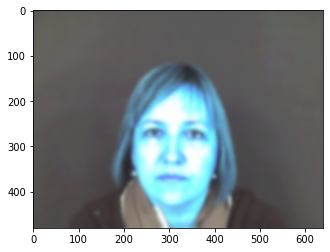

**Changing Segmantation Model to Encoder-Decoder**

In [ ]:

from keras.utils import plot_model
BACKBONE = 'mobilenetv2'

model = sm.Unet(BACKBONE, input_shape = (224, 224, 3))

model.layers.pop()
model.layers.pop()
# model.layers.pop()


x = tf.keras.layers.Conv2D(3, (1,1))(model.layers[-3].output) #This version of keras flan flan
model = tf.keras.models.Model(model.layers[0].output, x)



#metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


#model.compile(optimizer='adam', loss='mean_squared_error')
#plot_model(model, to_file='model.png')
model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________

**Configurations**

In [ ]:
EPOCHS = 200
TRAIN_BATCH_SIZE = 32
TRAIN_STEPS_PER_EPOCH = 60
VAL_BATCH_SIZE = 32
VAL_STEPS_PER_EPOCH = 15

dataset_train = Dataset(train_X, train_Y, TRAIN_BATCH_SIZE)
dataset_val = Dataset(val_X, val_Y, VAL_BATCH_SIZE)

train_generator = dataset_train.input_tensors
val_generator = dataset_val.input_tensors

**Model Training**

In [ ]:
weights_filepath = "/content/gdrive/My Drive/ThermalImageTest/weights/model_{epoch:02d}-{val_loss:.2f}-{accurracy}.hdf5"

model_callbacks = tf.keras.callbacks.ModelCheckpoint(
    filepath = weights_filepath,
    save_weights_only=False,
    save_best_only=False
)

history = model.fit_generator(
    train_generator, steps_per_epoch=TRAIN_STEPS_PER_EPOCH, epochs=EPOCHS,
    validation_data=val_generator, validation_steps=VAL_STEPS_PER_EPOCH,
    verbose=1, callbacks=[model_callbacks], shuffle=True
)

Epoch 1/200
60/60 [==============================] - 54s 906ms/step - loss: 9325.7920 - val_loss: 6794.3887
Epoch 2/200
60/60 [==============================] - 54s 900ms/step - loss: 9187.8467 - val_loss: 8375.2861
Epoch 3/200
60/60 [==============================] - 54s 896ms/step - loss: 9032.3184 - val_loss: 8563.9521
Epoch 4/200
60/60 [==============================] - 54s 893ms/step - loss: 8832.6436 - val_loss: 8351.3359
Epoch 5/200
60/60 [==============================] - 54s 895ms/step - loss: 8578.7012 - val_loss: 8213.0127
Epoch 6/200
60/60 [==============================] - 53s 891ms/step - loss: 8273.4258 - val_loss: 8004.0425
Epoch 7/200
60/60 [==============================] - 54s 896ms/step - loss: 7940.4971 - val_loss: 7692.7017
Epoch 8/200
60/60 [==============================] - 53s 886ms/step - loss: 7575.4512 - val_loss: 7164.9609
Epoch 9/200
60/60 [==============================] - 54s 892ms/step - loss: 7128.8564 - val_loss: 7168.4463
Epoch 10/200
60/60 [========

## Ploting the Graph

In [ ]:
def plot_training(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(train_loss))
    
    plt.plot(epochs, train_loss, 'b')
    plt.plot(epochs, val_loss, 'r')
    plt.title('Training and Validation Loss')
    plt.savefig('/content/gdrive/My Drive/ThermalImageTest/loss_results1200Gaussian.jpg')
    plt.show()

    
plot_training(history)